In [1]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [2]:
# Annotations structure
file = './datasets/Room_all_agents/Room1/Setting1/8m/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

/tmp/ipykernel_1052278/566450777.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.499364,0.000094,0.117077,2.107222,-0.783901,True,6.918802,0.082890,True,6.357754,0.892982,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.497246,0.000766,0.395836,1.800532,-1.312243,True,6.669603,-1.835180,True,6.347177,-0.898825,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.485843,0.007717,0.725341,1.269790,-1.777184,False,5.684648,-3.913701,True,5.676816,-2.914395,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.475703,0.019575,1.031016,0.675467,-2.030959,False,4.195889,-5.452686,True,4.486544,-4.485341,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.466661,0.039314,1.287408,0.139663,-2.092604,False,2.620631,-6.332658,False,3.149596,-5.458576,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [3]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/Room_all_agents/*'))+1):
    room_dir = f'./datasets/Room_all_agents/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'

        for agent_dir in glob(f'{set_dir}/*'):
            agent = agent_dir.split('/')[-1]

            for ep_dir in sorted(glob(f'{agent_dir}/episode_*')):     

                ep = ep_dir.split('/')[-1]
                try:
                    with open(f'{ep_dir}/{ep}.pkl', 'rb') as f:
                        df = pickle.load(f)
                        df.insert(0, 'agent', pd.Series(data=[agent for _ in range(df.shape[0])], dtype=str))
                        df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                        df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                        ep_dfs.append(df)
                except FileNotFoundError:
                    print(f'[WARN] File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,6000000,1,1,2.5,0.0,-2.511899,-0.000324,0.064005,...,0.971636,-5.042394,False,0.939695,-2.672393,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,6000000,1,2,2.5,0.0,-2.538352,-0.003958,0.220937,...,0.202131,-5.149991,False,0.542664,-2.781755,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,6000000,1,3,2.5,0.0,-2.564896,-0.012329,0.437258,...,-0.881970,-5.099983,False,-0.024519,-2.821527,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,6000000,1,4,2.5,0.0,-2.581863,-0.022204,0.718748,...,-2.253910,-4.679027,False,-0.768752,-2.690010,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,6000000,1,5,2.5,0.0,-2.578010,-0.015496,1.005735,...,-3.509466,-3.866783,False,-1.486116,-2.346344,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [5]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/Room_all_agents/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/Room_all_agents/annotations.pkl')

# 2. Image Analysis

In [173]:
file = './datasets/Room_all_agents/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    ep_dfs = ep_dfs[ep_dfs['room'] == 2]
    ep_dfs.reset_index(inplace=True, drop=True)
    display(ep_dfs.head())

print(f"Number of records: {ep_dfs.shape[0]}")

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of records: 8753


In [174]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
agent = anchor_rec['agent']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('2', '3', '0005', '00058')

In [175]:
anchor_rec

room                                                                 2
setting                                                              3
agent                                                           400000
episode                                                              5
step                                                                58
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                  -2.069999
robot_pos_y                                                  -0.562381
robot_yaw                                                    -1.616612
robot_1_rel_pos_x                                             0.493417
robot_1_rel_pos_y                                             7.061534
robot_1_in_fov                                                   False
robot_2_rel_pos_x                                             3.200359
robot_

In [176]:
# Look for positive examples in either other rooms or settings or other agents
pos_df = ep_dfs[(ep_dfs['room'] != anchor_rec['room']) | (ep_dfs['setting'] != anchor_rec['setting']) | (ep_dfs['agent'] != anchor_rec['agent'])].copy()
pos_df

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,2,3,8m,5,86,2.5,0.0,1.940749,0.103740,-0.132197,...,-6.194475,-2.927711,False,-5.179220,-4.400761,False,"{'scan': [[0.13120943], [0.1346703], [0.138357...",9.0,10.0,11.0
8749,2,3,8m,5,87,2.5,0.0,1.991763,0.096320,-0.157763,...,-6.163866,-3.083260,False,-5.137458,-4.532350,False,"{'scan': [[0.14208236], [0.14566554], [0.14947...",9.0,10.0,11.0
8750,2,3,8m,5,88,2.5,0.0,2.042558,0.087611,-0.183483,...,-6.128777,-3.235537,False,-5.091092,-4.658668,False,"{'scan': [[0.15766236], [0.16162385], [0.16583...",9.0,10.0,11.0
8751,2,3,8m,5,89,2.5,0.0,2.093258,0.077597,-0.207789,...,-6.097354,-3.377372,False,-5.046530,-4.772039,False,"{'scan': [[0.16784842], [0.17175904], [0.17591...",9.0,10.0,11.0


In [177]:
# Look for negative examples in other episodes of the same setting of the room
neg_df = ep_dfs[(ep_dfs['room'] == anchor_rec['room']) & (ep_dfs['setting'] == anchor_rec['setting']) & ((ep_dfs['episode'] != anchor_rec['episode']) | (ep_dfs['agent'] != anchor_rec['agent']))].copy()
neg_df

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
5969,2,3,6000000,1,1,2.5,0.0,-2.485229,0.000237,0.043348,...,1.013576,-0.399591,True,0.169913,4.473410,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5970,2,3,6000000,1,2,2.5,0.0,-2.448655,0.003973,0.161162,...,0.923096,-0.514355,True,0.661154,4.411649,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5971,2,3,6000000,1,3,2.5,0.0,-2.405415,0.012970,0.238957,...,0.837917,-0.594961,True,0.958516,4.327054,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5972,2,3,6000000,1,4,2.5,0.0,-2.358581,0.025484,0.282980,...,0.759636,-0.646531,True,1.097612,4.260430,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5973,2,3,6000000,1,5,2.5,0.0,-2.313094,0.039940,0.334977,...,0.669026,-0.698243,True,1.265112,4.178057,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,2,3,8m,5,86,2.5,0.0,1.940749,0.103740,-0.132197,...,-6.194475,-2.927711,False,-5.179220,-4.400761,False,"{'scan': [[0.13120943], [0.1346703], [0.138357...",9.0,10.0,11.0
8749,2,3,8m,5,87,2.5,0.0,1.991763,0.096320,-0.157763,...,-6.163866,-3.083260,False,-5.137458,-4.532350,False,"{'scan': [[0.14208236], [0.14566554], [0.14947...",9.0,10.0,11.0
8750,2,3,8m,5,88,2.5,0.0,2.042558,0.087611,-0.183483,...,-6.128777,-3.235537,False,-5.091092,-4.658668,False,"{'scan': [[0.15766236], [0.16162385], [0.16583...",9.0,10.0,11.0
8751,2,3,8m,5,89,2.5,0.0,2.093258,0.077597,-0.207789,...,-6.097354,-3.377372,False,-5.046530,-4.772039,False,"{'scan': [[0.16784842], [0.17175904], [0.17591...",9.0,10.0,11.0


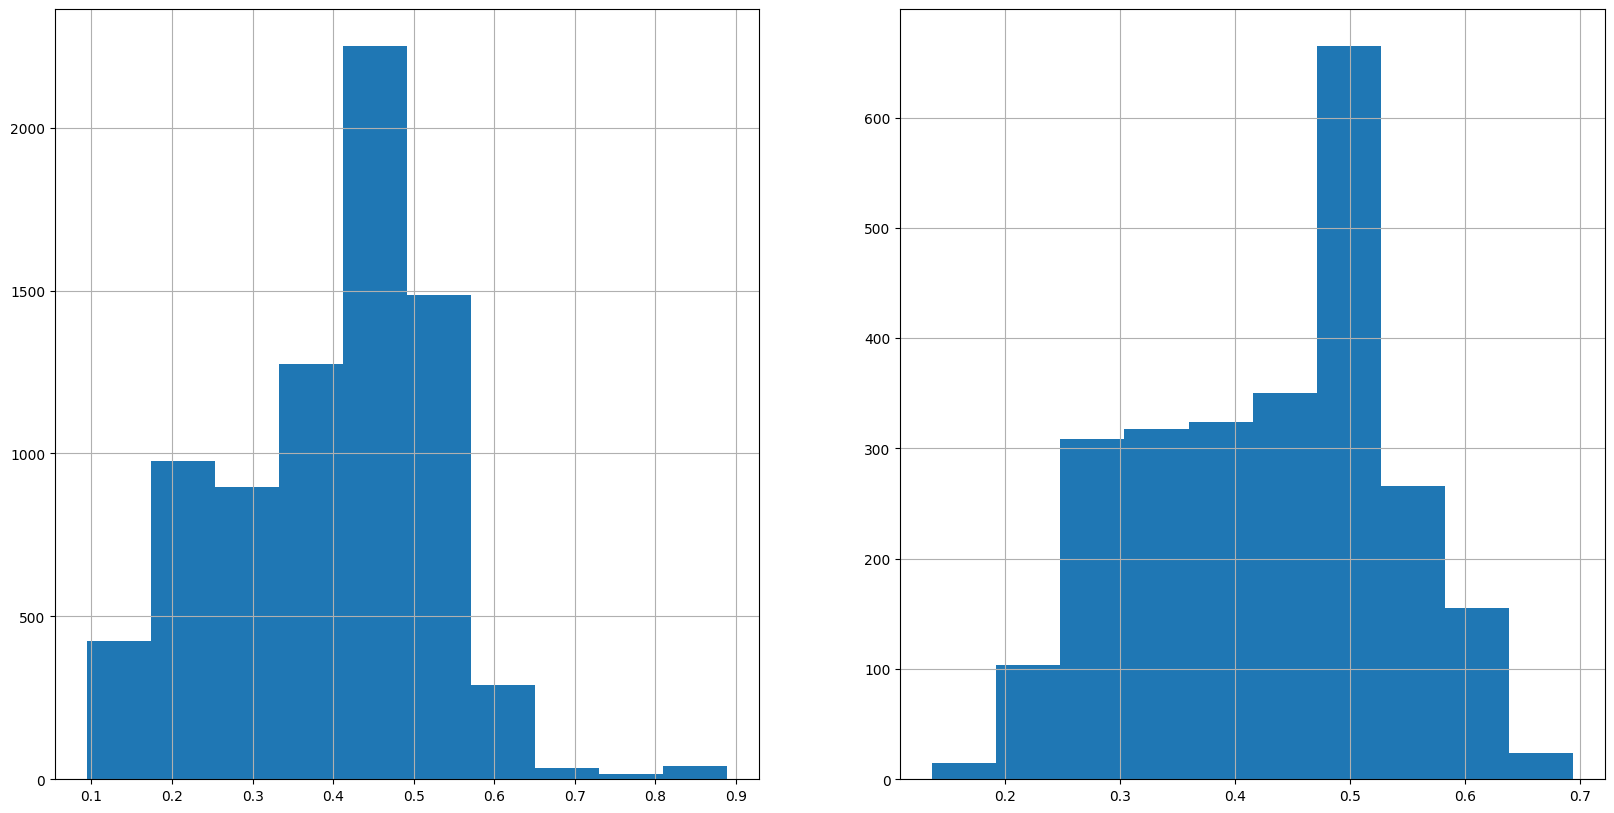

In [178]:
# Weight vector
anc_scan = anchor_rec.laser_readings['scan'].squeeze()
w = np.zeros(anc_scan.shape[0])
# In FOV readings (consider only them for binary masking)
w[64:164] += 1 
# Out of FOV readings (consider also them for soft masking)
x = np.linspace(0.0, 1.0, w[164:].shape[0])
sigmoid = 1 - 0.9*(1 / (1+np.exp(-x))) # Sigmoid 1.0 -> 0.1
w[164:] += sigmoid
w[63::-1] += sigmoid

# Normalizer
den = np.sqrt(w.sum())

# Normalized weighted Eucledian distances on LiDAR readings 
pos_l2_dist = pos_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)
neg_l2_dist = neg_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_l2_dist.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_l2_dist.hist(ax=bx);

-5 -5


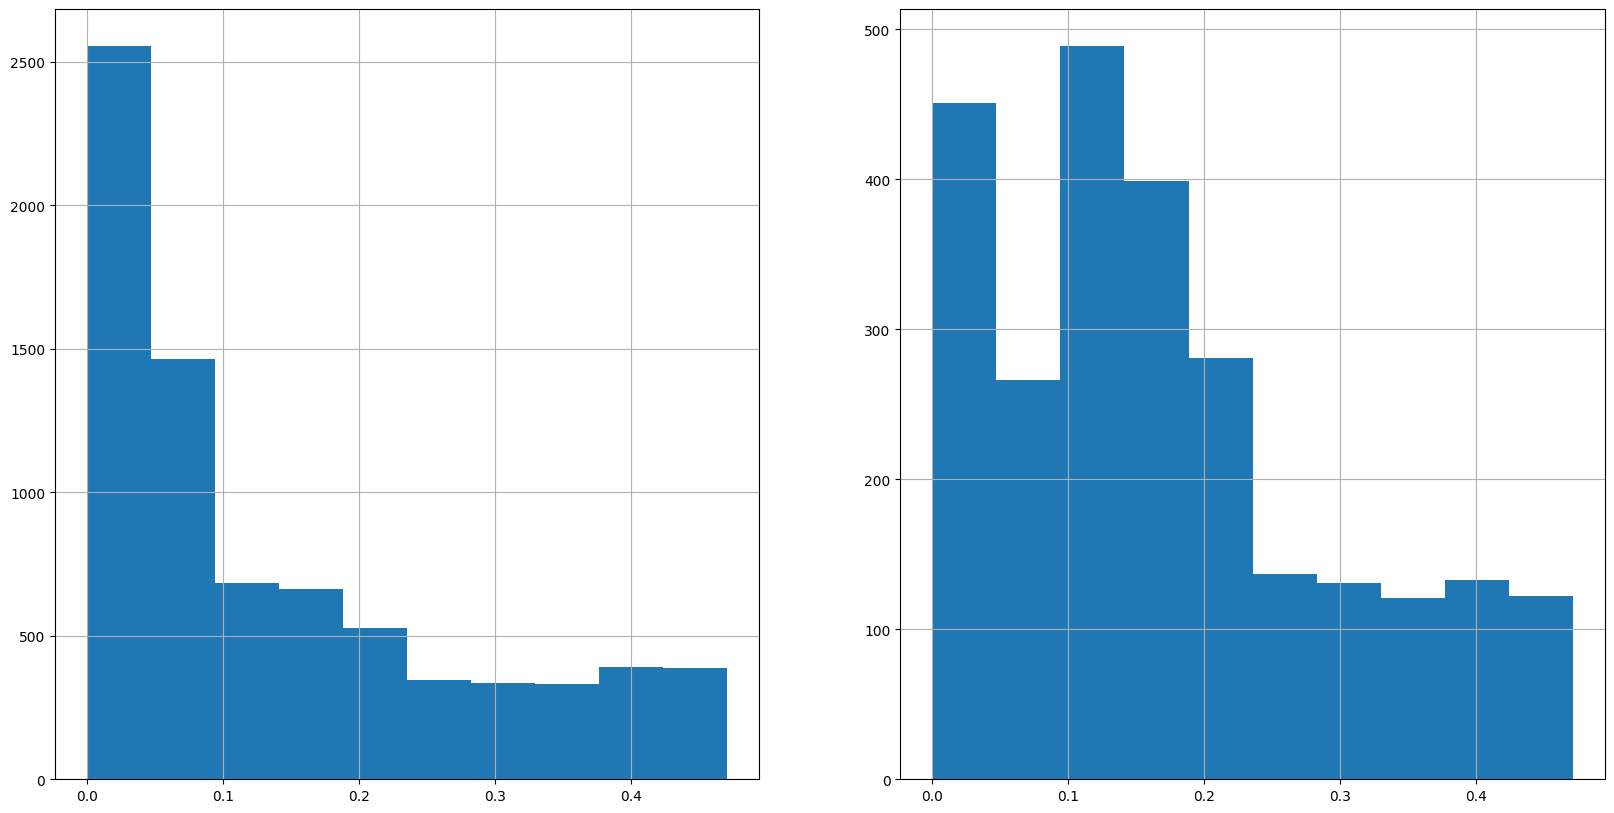

In [179]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
pos_gd_diffs = pos_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd 
neg_gd_diffs = neg_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_gd_diffs.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_gd_diffs.hist(ax=bx);

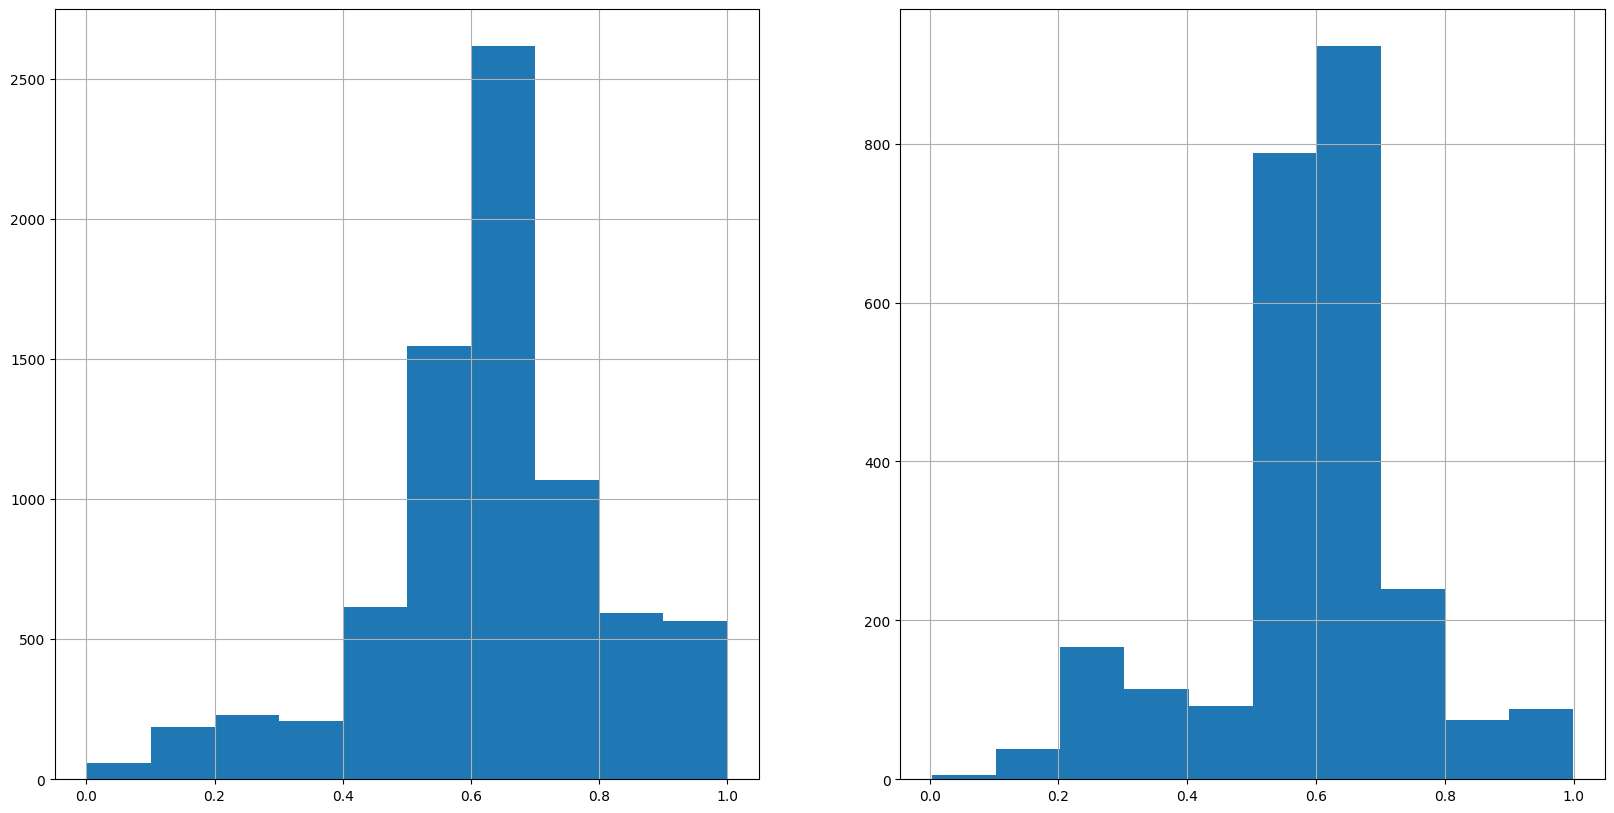

In [180]:
# Normalize angle between [-pi, pi]
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Compute angle with respect to the goal considering robot's orientation
def relative_angle(record):
    # Info
    robot_x, robot_y = record['robot_pos_x'], record['robot_pos_y']
    goal_x, goal_y = record['target_point_x'], record['target_point_y']
    theta_r = record['robot_yaw'] 

    # Relative angle
    dx = goal_x - robot_x
    dy = goal_y - robot_y
    theta_g = np.arctan2(dy, dx)
    return normalize_angle(theta_g - theta_r)

# Orientation towards goal position
anchor_phi = relative_angle(anchor_rec)
pos_ori_diff = pos_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1) 
neg_ori_diff = neg_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_ori_diff.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_ori_diff.hist(ax=bx);

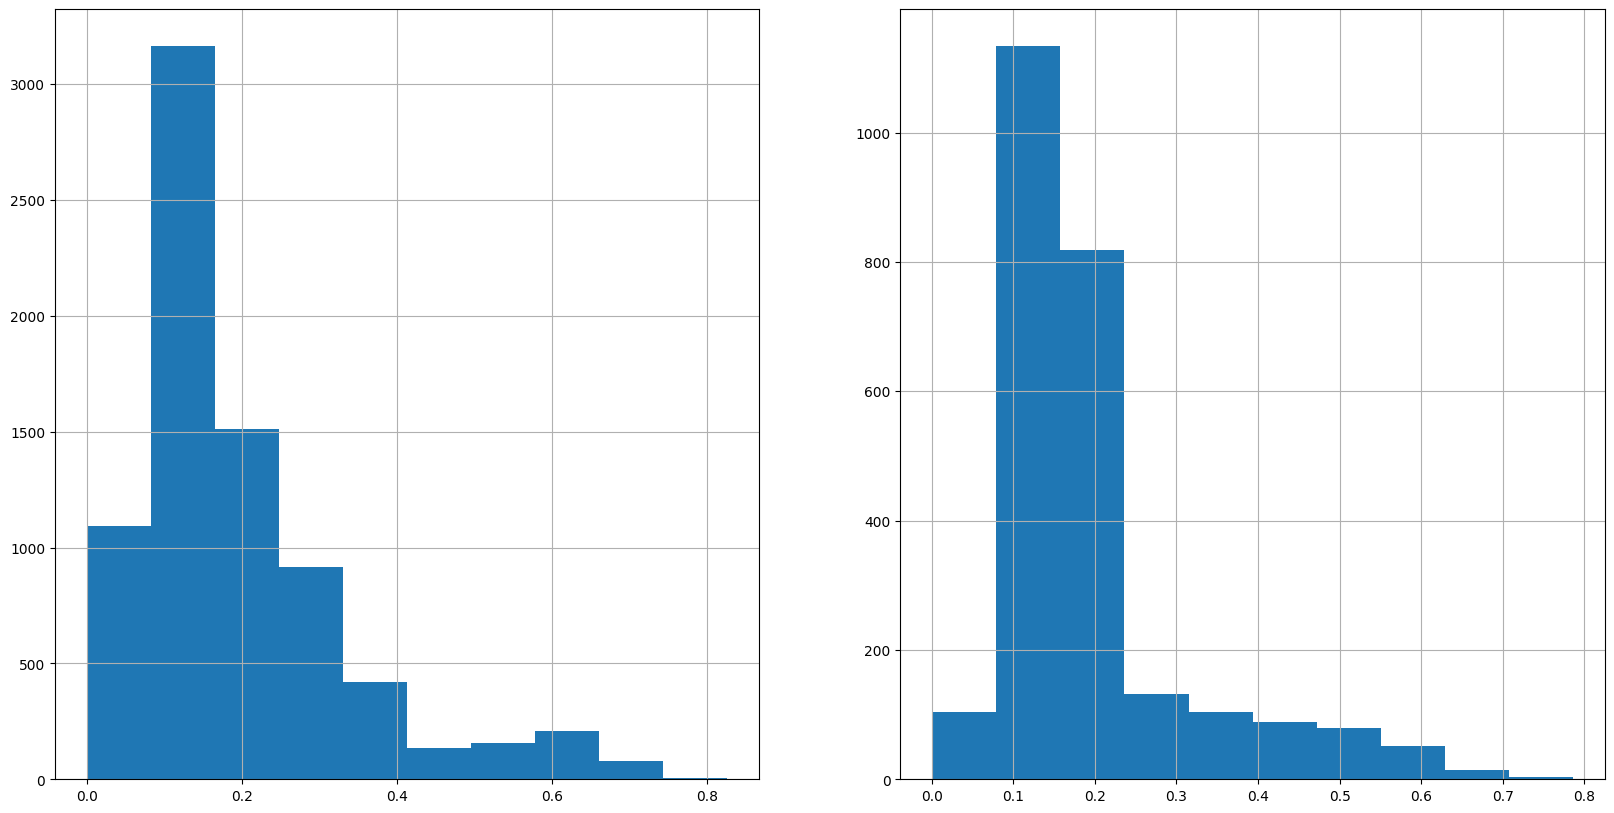

In [181]:
# Combine distances for computing similarities
pos_sim_scores = (1 - pos_l2_dist)*(1 - pos_gd_diffs)*(1 - pos_ori_diff)
neg_sim_scores = (1 - neg_l2_dist)*(1 - neg_gd_diffs)*(1 - neg_ori_diff)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_sim_scores.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_sim_scores.hist(ax=bx);

In [182]:
# Negative examples mining
BASE_NEG_DIST = 0.2
N_NEG_SAMPLES = 12

negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.05
    negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

7034    0.185695
7384    0.146549
7332    0.166233
6522    0.151704
7786    0.184611
6316    0.118794
6808    0.124936
7986    0.032441
7204    0.126653
8388    0.171471
6407    0.148107
6021    0.119395
dtype: float64

In [183]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
7034,2,3,3200000,3,85,2.5,0.0,1.798348,0.181126,-0.449744,...,-4.435942,-1.361205,False,1.573399,-4.104032,False,"{'scan': [[0.12741432], [0.12385576], [0.12052...",9.0,10.0,11.0
7384,2,3,400000,1,152,2.5,0.0,0.200904,-2.015381,2.986206,...,0.081272,1.940804,False,-4.596752,1.981950,False,"{'scan': [[0.27467906], [0.27059963], [0.26672...",9.0,10.0,11.0
7332,2,3,400000,1,100,2.5,0.0,-0.116144,-1.950708,2.968560,...,-0.150690,1.877300,False,-4.214576,1.703652,False,"{'scan': [[0.2630099], [0.25895172], [0.255100...",9.0,10.0,11.0
6522,2,3,6000000,5,7,2.5,0.0,-2.645074,-0.062990,0.399061,...,2.226027,-0.735468,True,5.361528,-2.787902,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
7786,2,3,400000,3,44,2.5,0.0,-0.708004,-0.205810,-0.308055,...,-2.186690,-2.482024,False,-1.168782,3.171953,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
6316,2,3,6000000,2,93,2.5,0.0,1.854480,0.658049,-0.284580,...,-1.934384,-5.722729,False,-4.511975,-7.423546,False,"{'scan': [[0.23125015], [0.2267158], [0.222426...",9.0,10.0,11.0
6808,2,3,3200000,1,53,2.5,0.0,0.156704,0.178968,0.008892,...,-2.483803,-1.017503,False,0.865517,0.632508,True,"{'scan': [[0.087444715], [0.08646945], [0.0855...",9.0,10.0,11.0
7986,2,3,400000,4,195,2.5,0.0,-3.182061,-1.387849,1.808757,...,6.593252,-1.086713,True,6.970298,-1.324863,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
7204,2,3,3200000,5,67,2.5,0.0,0.787840,0.288919,0.087100,...,0.373854,2.781809,False,2.154082,1.199061,True,"{'scan': [[0.106856905], [0.10588589], [0.1049...",9.0,10.0,11.0
8388,2,3,8m,1,87,2.5,0.0,1.968635,0.170013,-0.263617,...,-0.434924,2.130477,False,2.275038,-3.003964,True,"{'scan': [[0.11780729], [0.12019905], [0.12272...",9.0,10.0,11.0


In [184]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_agent = neg_rec['agent']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/Room_all_agents/Room{neg_room}/Setting{neg_set}/{neg_agent}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [185]:
# Positive examples mining
BASE_POS_DIST = 0.8
N_POS_SAMPLES = 4

positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.001
    positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

2280    0.736932
2179    0.823293
2358    0.739726
2177    0.747620
dtype: float64

In [186]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
2280,2,1,400000,4,110,2.5,0.0,-0.676015,1.021035,-2.161010,...,-6.084753,2.734381,False,-0.405943,5.324594,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2179,2,1,400000,4,9,2.5,0.0,-2.433971,-0.167394,-1.658624,...,-5.867049,6.112040,False,-0.566950,6.379599,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2358,2,1,400000,4,188,2.5,0.0,-0.976472,0.921085,-2.167628,...,-5.985809,2.525514,False,-0.697615,5.623298,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2177,2,1,400000,4,7,2.5,0.0,-2.434098,-0.105943,-1.476499,...,-4.582411,7.010749,False,0.659730,6.387631,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [187]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_agent = pos_rec['agent']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/Room_all_agents/Room{pos_room}/Setting{pos_set}/{pos_agent}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

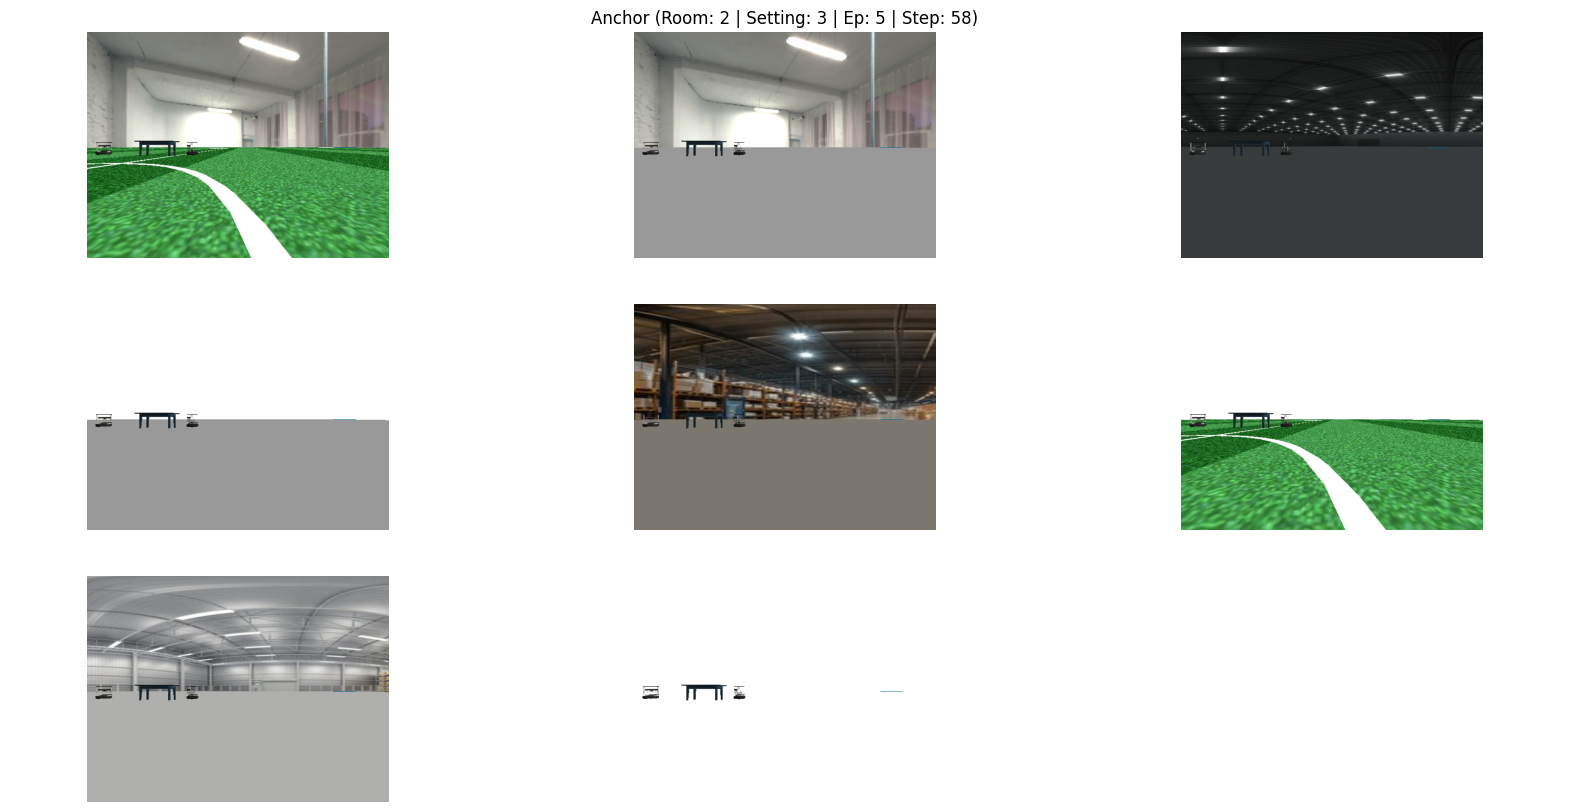

In [188]:
# Anchor image
anc_img = Image.open(f'./datasets/Room_all_agents/Room{room}/Setting{setting}/{agent}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/Room_all_agents/Room{room}/Setting{setting}/{agent}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

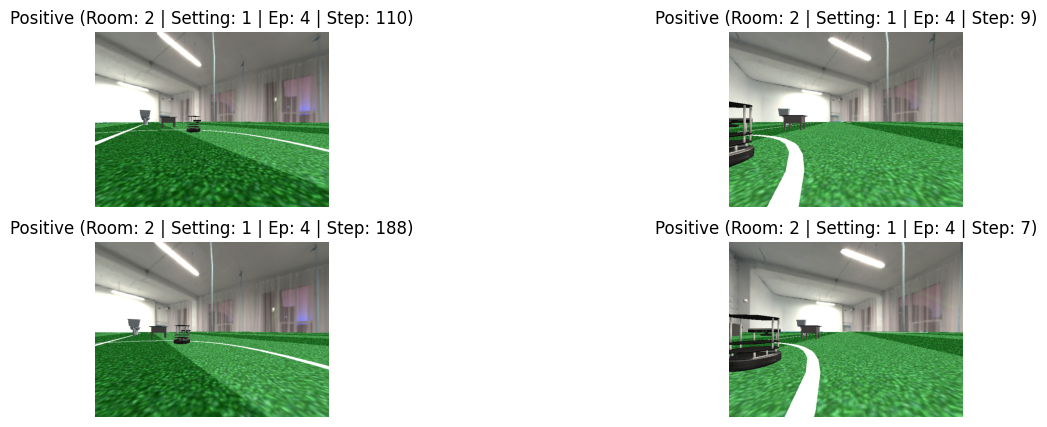

In [189]:
N_ROWS = 2
N_COLS = 2

# Plot positive examples by similarity
plt.figure(figsize=[15,5])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

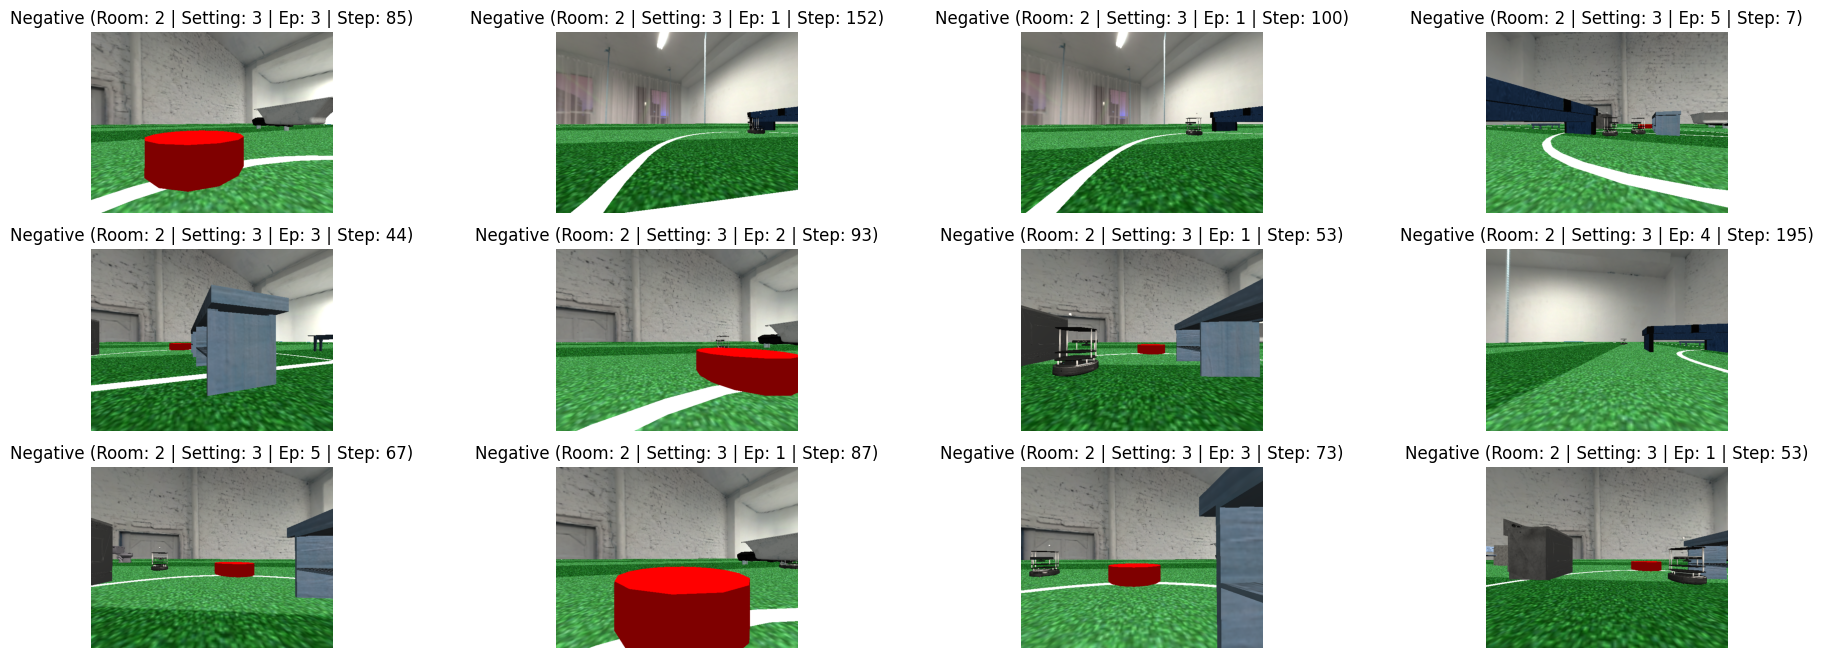

In [190]:
N_ROWS = 3
N_COLS = 4

# Plot negative examples by similarity
plt.figure(figsize=[23,8])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();